In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import GPyOpt
from torchvision import datasets, transforms, utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score
from scipy.stats import uniform
import random
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch
# Models
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils import resample
#one hot encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Score Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

from tqdm import tqdm
#plot spectrogram
from matplotlib.pyplot import specgram

#mixup
import random
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
#from mixup import mix, mixupreg, converttohardlabel
#from mixup import mix

from scipy import stats

#CM
from sklearn.metrics import confusion_matrix
np.random.seed(32)
random.seed(32)

In [2]:
# Mixing two training data points and returning the mixed data point and its label between 0 and 1
def mix(eeg_info_1=None, eeg_info_2=None, lambd=None):

    X1, X2 = eeg_info_1["eeg"], eeg_info_2["eeg"]

    y1, y2 = eeg_info_1["label"], eeg_info_2["label"]

    mix_X = X1 * lambd + X2 * (1. - lambd)

    label = y1 * lambd + y2 * (1. - lambd)

    return mix_X, label

In [17]:
def mixupreg(X_train = None, y_train = None, size = None, alpha = None):
    # Number of mixup augmentation examples - default is
    #N = int(len(y_train) / 10) if not size or size > len(y_train) else size
    N = size
    N2 = int(N/2)
    print(N2)
    # If method is 'split' we need 10 extra examples per mixed example, since we will generate 10 new
    # examples for each mixup data point


    mix_Xs = np.zeros((N2, np.size(X_train, 1)))
    mix_ys = np.zeros((N2, np.size(y_train, 1)))

    # choose mixup batch randomly from the training data
    #indices = np.random.permutation(len(X_train))[:N * 2]

    #N2 = int(len(indices) / 2) if N >= np.size(y_train, 0) / 2 else N
    
    X_1, X_2 = X_train[:N2], X_train[N2:2*N2]
    y_1, y_2 = y_train[:N2], y_train[N2:2*N2]
    print(y_1.shape, y_2.shape)
    #X_1, X_2 = X_train[indices[:N2]], X_train[indices[N2:]]
    #y_1, y_2 = y_train[indices[:N2]], y_train[indices[N2:]]
    #print(y_train.shape(), y_1.shape())

    
   
    for i in range(len(y_1)):
        eeg_info_1, eeg_info_2 = {"eeg": X_1[i], "label": y_1[i]}, {"eeg": X_2[i], "label": y_2[i]}
        #lambd = np.random.uniform(0.1, 0.4)  # must be beta
        lambd = np.random.beta(alpha, alpha) 
        print(lambd)
        mix_X, mix_y = mix(eeg_info_1=eeg_info_1, eeg_info_2=eeg_info_2, lambd=lambd)
        mix_Xs[i] = mix_X
        mix_ys[i] = mix_y
    #print(mix_ys)

    return mix_Xs, mix_ys

In [18]:
def converttohardlabel(y_pred_mix, method=''):

    y_pred_mix_hard = np.zeros((np.size(y_pred_mix,0),np.size(y_pred_mix,1)))

    if method == 'Maximum likelihood':
        for i in range(len(y_pred_mix)):  # loop over rows
            
            if np.argmax(y_pred_mix, axis=1)[i] == 5:
                y_pred_mix_hard[i] = [0, 0, 0, 0 , 0, 1]
                
            elif np.argmax(y_pred_mix, axis=1)[i] == 4:
                y_pred_mix_hard[i] = [0, 0, 0, 0 ,1, 0]

            elif np.argmax(y_pred_mix, axis=1)[i] == 3:
                y_pred_mix_hard[i] = [0, 0, 0, 1, 0, 0]
                
            elif np.argmax(y_pred_mix, axis=1)[i] == 2:
                y_pred_mix_hard[i] = [0, 0, 1, 0, 0, 0]
            
            elif np.argmax(y_pred_mix, axis=1)[i] == 1:
                y_pred_mix_hard[i] = [0, 1, 0, 0, 0, 0]

            elif np.argmax(y_pred_mix, axis=1)[i] == 0:
                y_pred_mix_hard[i] = [1, 0, 0, 0, 0, 0]
                
            else:
                print(y_pred_mix[i])

    return y_pred_mix_hard

In [19]:
#BINARY
def converttohardlabel(y_pred_mix, method=''):

    y_pred_mix_hard = np.zeros((np.size(y_pred_mix,0),np.size(y_pred_mix,1)))

    if method == 'Maximum likelihood':
        for i in range(len(y_pred_mix)):  # loop over rows
            
            if np.argmax(y_pred_mix, axis=1)[i] == 5:
                y_pred_mix_hard[i] = [0, 0, 0, 0 , 0, 1]
                
            elif np.argmax(y_pred_mix, axis=1)[i] == 4:
                y_pred_mix_hard[i] = [0, 0, 0, 0 ,1, 0]

            elif np.argmax(y_pred_mix, axis=1)[i] == 3:
                y_pred_mix_hard[i] = [0, 0, 0, 1, 0, 0]
                
            elif np.argmax(y_pred_mix, axis=1)[i] == 2:
                y_pred_mix_hard[i] = [0, 0, 1, 0, 0, 0]
            
            elif np.argmax(y_pred_mix, axis=1)[i] == 1:
                y_pred_mix_hard[i] = [0, 1, 0, 0, 0, 0]

            elif np.argmax(y_pred_mix, axis=1)[i] == 0:
                y_pred_mix_hard[i] = [1, 0, 0, 0, 0, 0]
                
            else:
                print(y_pred_mix[i])

    return y_pred_mix_hard

In [20]:
#load data
label_dict = {'chew': 0, 'elpp': 1, 'eyem': 2, 'musc': 3, 'shiv': 4, 'null': 5}


print('loading data')
X = np.load("/Users/yeganehghamari/epilepsy-project/data/X1.npy")
Y = np.load("/Users/yeganehghamari/epilepsy-project/data/Y1.npy")
G = np.load("/Users/yeganehghamari/epilepsy-project/data/groups1.npy")

X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
nan_filter = ~np.isnan(X).any(axis=1)
X = X[nan_filter]
Y = Y[nan_filter]
G = G[nan_filter]
# if window has both null and artifact, delete artifact
for i in range(len(Y)):
    if np.sum(Y[i]) > 1:
        Y[i][5] = 0

#%%

# delete all windows with more than one artifact (not very many)
X = np.delete(X, np.where(np.sum(Y, axis=1) != 1), axis=0)
G = np.delete(G, np.where(np.sum(Y, axis=1) != 1), axis=0)
Y = np.delete(Y, np.where(np.sum(Y, axis=1) != 1), axis=0)

#convert to class labels
y_class = Y.argmax(1)

loading data


In [21]:
np.shape(y_class), np.shape(Y), np.shape(X)

((686463,), (686463, 6), (686463, 475))

In [22]:
#split data
Gidxs = resample(np.unique(G), replace=False, n_samples=int(0.8 * len(np.unique(G))))

Xtrain, ytrain, Gtrain = X[np.isin(G, Gidxs)], y_class[np.isin(G, Gidxs)], G[np.isin(G, Gidxs)]


Xtest, ytest, Gtest = X[~np.isin(G, Gidxs)], y_class[~np.isin(G, Gidxs)], G[~np.isin(G, Gidxs)]


Xtrain_copy, ytrain_copy, Xtest_copy, ytest_copy = Xtrain, ytrain, Xtest, ytest

In [23]:
np.shape(Xtrain), np.shape(ytrain), np.shape(Xtest), np.shape(ytest), np.shape(Gtrain), np.shape(Gtest)

((536862, 475), (536862,), (149601, 475), (149601,), (536862,), (149601,))

In [24]:
np.count_nonzero(ytrain==0), np.count_nonzero(ytrain==1), np.count_nonzero(ytrain==2), np.count_nonzero(ytrain==3), np.count_nonzero(ytrain==4),np.count_nonzero(ytrain==5)

(5230, 4713, 12393, 8729, 1542, 504255)

In [25]:
#undersample null
null_idxs = np.where(ytrain == 5)[0]
#artifact_idxs = np.where(Y_train[:,5] != 1)[0]
print(null_idxs.shape)

#undersampling null class
mask = resample(null_idxs, replace=False, n_samples=509831 - 20000)

Xtrain = np.delete(Xtrain, mask, axis=0)
ytrain = np.delete(ytrain, mask, axis=0)
np.count_nonzero(ytrain ==5), ytrain.shape,Xtrain.shape

(504255,)


(14424, (47031,), (47031, 475))

In [26]:
#choose batch from training set
N = 1000
#N = 1/10


zeros, ones, twos, threes, fours, fives = np.where(ytrain==0)[0], np.where(ytrain==1)[0], np.where(ytrain==2)[0], np.where(ytrain==3)[0], np.where(ytrain==4)[0], np.where(ytrain==5)[0]
zeros, ones, twos, threes, fours, fives = shuffle(zeros), shuffle(ones), shuffle(twos), shuffle(threes), shuffle(fours), shuffle(fives) 
zero, one, two, three, four, five = zeros[:N], ones[:N], twos[:N], threes[:N], fours[:N], fives[:N]
#zero, one, two, three, four, five = zeros[:int(N*len(zeros))], ones[:int(N*len(ones))], twos[:int(N*len(twos))], threes[:int(N*len(threes))], fours[:int(N*len(fours))], fives[:int(N*len(fives))]

ind = np.concatenate((zero, one, two, three, four, five))

#Xtrain, ytrain = Xtrain[ind], ytrain[ind]
Xtrain, ytrain = Xtrain[:int(N*len(ytrain))], ytrain[:int(N*len(ytrain))]
#shuffler = np.random.permutation(len(Xtrain))
#Xtrain, ytrain = Xtrain[shuffler], ytrain[shuffler]
Xtrain, ytrain = shuffle(Xtrain, ytrain)
Xtest, ytest = shuffle(Xtest, ytest)
#shuffler2 = np.random.permutation(len(Xtest))
#Xtest, ytest = Xtest[shuffler2], ytest[shuffler2]

#Xtrain = [Xtrain[i] + np.random.rand for i in range(len(Xtrain))]
# print some information
#standardize
scaler = StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

print('Information about the new datasets')
print('Training set shape:', Xtrain.shape)
print('Test set shape', Xtest.shape)
print(ytrain.shape, ytest.shape)

Information about the new datasets
Training set shape: (47031, 475)
Test set shape (149601, 475)
(47031,) (149601,)


In [27]:
zero.shape, one.shape, two.shape, three.shape, four.shape, five.shape

((1000,), (1000,), (1000,), (1000,), (1000,), (1000,))

In [28]:
ytrain[0]

2

In [29]:
ohe = OneHotEncoder()
ohe.fit([[0],[1],[2],[3],[4],[5]])
ytrain = ohe.transform(ytrain.reshape(-1,1)).toarray()
ytest = ohe.transform(ytest.reshape(-1,1)).toarray()
np.shape(ytrain), np.shape(ytest), np.shape(Xtrain), np.shape(Xtest)

((47031, 6), (149601, 6), (47031, 475), (149601, 475))

In [30]:
ytrain[0]

array([0., 0., 1., 0., 0., 0.])

In [31]:
model = MLPRegressor(activation = 'logistic')
model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)
ypred

array([[ 0.03152315, -0.02756771,  0.5680713 , -0.03531571,  0.01447692,
         0.44313713],
       [ 0.05169038, -0.08184024,  0.35349806, -0.10209886, -0.02574399,
         0.82023871],
       [ 0.29983577, -0.12381348,  0.52217298,  0.45892326,  0.01326088,
        -0.15680392],
       ...,
       [ 0.2787302 ,  0.08105107, -0.12323664,  0.51557283,  0.12619502,
         0.12747547],
       [-0.12631727,  0.08632041,  0.5254939 ,  0.07301231, -0.10937259,
         0.53927238],
       [-0.08859527,  0.30807724,  0.82562312, -0.02132607,  0.02441253,
        -0.03509395]])

In [32]:
stats.describe(ypred)

DescribeResult(nobs=149601, minmax=(array([-0.48540248, -0.62798282, -1.26809195, -0.92874942, -0.39550451,
       -1.09202749]), array([0.95506189, 1.5373099 , 1.86882697, 1.50206049, 0.51491995,
       2.23607773])), mean=array([0.01446892, 0.05452099, 0.24393411, 0.13090248, 0.03559944,
       0.52724205]), variance=array([0.01774956, 0.03139247, 0.12483117, 0.07438001, 0.00729091,
       0.16690623]), skewness=array([ 1.08333874,  0.70605239,  0.14680003,  0.28216699,  0.25538258,
       -0.04039286]), kurtosis=array([ 2.94364547,  2.30417879,  0.03475664,  0.26103959,  0.46007174,
       -0.11138247]))

In [33]:
y_pred_classes = ypred.argmax(1)
y_test_classes = ytest.argmax(1)
y_test_classes, y_pred_classes
y_test_classes.shape, y_pred_classes.shape

((149601,), (149601,))

In [34]:
np.count_nonzero(y_pred_classes == y_test_classes)/len(y_pred_classes)
y_pred_classes[0], y_test_classes[0]

(2, 5)

In [21]:
'''#convert to hard labels
ypred_hard = converttohardlabel(ypred, method = 'Maximum likelihood')
ypred_hard

#convert them to categorical classes
y_pred_classes = ypred_hard.argmax(1)
y_test_classes = ytest.argmax(1)
y_pred_classes, y_test_classes, ypred_hard'''

"#convert to hard labels\nypred_hard = converttohardlabel(ypred, method = 'Maximum likelihood')\nypred_hard\n\n#convert them to categorical classes\ny_pred_classes = ypred_hard.argmax(1)\ny_test_classes = ytest.argmax(1)\ny_pred_classes, y_test_classes, ypred_hard"

In [35]:
print(np.count_nonzero(y_pred_classes == 0), np.count_nonzero(y_pred_classes == 1), np.count_nonzero(y_pred_classes == 2), np.count_nonzero(y_pred_classes == 3), np.count_nonzero(y_pred_classes == 4), np.count_nonzero(y_pred_classes == 5)) 
print(np.count_nonzero(y_test_classes == 0), np.count_nonzero(y_test_classes == 1), np.count_nonzero(y_test_classes == 2), np.count_nonzero(y_test_classes == 3), np.count_nonzero(y_test_classes == 4), np.count_nonzero(y_test_classes == 5)) 





2181 3549 38973 17970 134 86794
575 1322 3948 1594 1588 140574


In [36]:
print('model without mixup: ', model)
#print("Train data: Accuracy:", np.mean(model.predict(X_train_mix) == y_train_mix) * 100)

print("Test data: Accuracy:", np.mean(y_pred_classes == y_test_classes) * 100)
print("Test data: Balanced accuracy:", balanced_accuracy_score(y_test_classes, y_pred_classes) * 100)
#print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
print("Test: Weighted F1-Score:", round(f1_score(y_test_classes, y_pred_classes, average='weighted') * 100, 3), '%')
print()
print(classification_report(y_test_classes, y_pred_classes))
print()
#print('Default model out of bag error', model.oob_score_)
#print('Default model train accuracy', model.score(Xtrain, ytrain))
#print('Default model test accuracy', model.score(Xtest, ytest))

model without mixup:  MLPRegressor(activation='logistic')
Test data: Accuracy: 58.30910221188361
Test data: Balanced accuracy: 31.392764829991965
Test: Weighted F1-Score: 69.965 %

              precision    recall  f1-score   support

           0       0.06      0.24      0.10       575
           1       0.05      0.15      0.08      1322
           2       0.06      0.59      0.11      3948
           3       0.03      0.29      0.05      1594
           4       0.19      0.02      0.03      1588
           5       0.97      0.60      0.74    140574

    accuracy                           0.58    149601
   macro avg       0.23      0.31      0.18    149601
weighted avg       0.91      0.58      0.70    149601




In [37]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((47031, 475), (47031, 6), (149601, 475), (149601, 6))

In [56]:
#add mixup to the training set
#X_train_mix, y_train_mix = mixupreg(X_train_res, y_train_res, 100)
mix_Xs, mix_ys = mixupreg(Xtrain, ytrain, 200, alpha= 0.4)
# Add mixups to training set
X_train_mix, y_train_mix = np.concatenate([mix_Xs, Xtrain]), np.concatenate([mix_ys, ytrain])

# Shuffle the data and the new mixup augmentations before returning
#shuffler = np.random.permutation(len(X_train_mix))
#X_train_mix, y_train_mix = X_train_mix[shuffler], y_train_mix[shuffler]
#X_train_mix, y_train_mix = shuffle(X_train_mix, y_train_mix)

scaler2 = StandardScaler().fit(X_train_mix)
X_train_mix = scaler2.transform(X_train_mix)
X_test_mix = scaler2.transform(Xtest)

100
(100, 6) (100, 6)
0.1891522318925251
0.9934999131578555
0.4688331614285604
0.17732985253690361
0.2562836144651176
0.02160867799810223
0.6757121152759689
0.008806785259490978
0.3298927577760354
0.6638168884682601
0.5092311024576841
0.9584265740646715
0.1992802810870526
0.9999813031214264
0.6552621176167998
0.00035491170469115115
0.9712614132879064
0.999987445041135
0.982372034855052
0.655259406947545
0.8795193186279738
0.7954850521481398
0.9983787320580498
0.0363042812235893
0.970769210385495
0.9339006652735468
0.9999999889200402
0.9884604540200531
0.529531379765681
0.04084079190472638
0.9941001467121421
0.9953339216241764
0.7245955902593656
0.5598728169909901
0.7361645868257375
0.11580847771153581
0.9699374497593658
0.8451051473609966
0.11481256216765187
0.6500831758773258
0.10606160800160246
0.07295320687060768
0.20166195495200434
0.9992753274864746
0.8626798517081434
0.7816449696958465
0.02048744867282255
0.5684160809378975
0.46088005418689343
0.49886951584686523
0.98561966307354

In [57]:
np.count_nonzero(np.argmax(mix_ys,1)==0), np.count_nonzero(np.argmax(mix_ys,1)==1), np.count_nonzero(np.argmax(mix_ys,1)==2), np.count_nonzero(np.argmax(mix_ys,1)==3), np.count_nonzero(np.argmax(mix_ys,1)==4),np.count_nonzero(np.argmax(mix_ys,1)==5)

(13, 9, 28, 17, 7, 26)

In [58]:
mix_ys.shape, mix_Xs.shape, Xtrain.shape, ytrain.shape

((100, 6), (100, 475), (47031, 475), (47031, 6))

In [59]:
model.fit(X_train_mix, y_train_mix)

ypred_mix = model.predict(X_test_mix)
ypred_mix

array([[ 0.1344947 , -0.0019707 ,  0.19062544, -0.02957118,  0.03655423,
         0.67057846],
       [ 0.14278893, -0.1315344 ,  0.59587539, -0.07704169, -0.03050162,
         0.49848665],
       [ 0.34780298, -0.02470343, -0.15063745,  0.31301908,  0.02900359,
         0.49468144],
       ...,
       [ 0.29810027,  0.46548633, -0.12578567,  0.41341565,  0.06490242,
        -0.11539324],
       [-0.11899361,  0.15815365,  0.85130646,  0.09032497,  0.10546704,
        -0.07528758],
       [-0.1787557 ,  0.18538936,  0.81887025,  0.40903126,  0.04695802,
        -0.2400408 ]])

In [60]:
stats.describe(ypred_mix)

DescribeResult(nobs=149601, minmax=(array([-0.47618732, -0.6428048 , -1.15438714, -1.04726282, -0.36188662,
       -1.29272174]), array([0.99657283, 1.40281112, 1.84713143, 1.44843443, 0.60097798,
       2.06258935])), mean=array([0.03167151, 0.07463864, 0.22049137, 0.13405067, 0.03575562,
       0.50776382]), variance=array([0.0198669 , 0.03096218, 0.12441892, 0.07482677, 0.00642196,
       0.16775392]), skewness=array([ 1.08057797,  0.64933137,  0.17371626,  0.25992002,  0.33541267,
       -0.03533262]), kurtosis=array([ 3.02280739,  2.01202391,  0.08780883,  0.1651688 ,  0.63906553,
       -0.10014265]))

In [61]:
y_pred_classes_mix = ypred_mix.argmax(1)
y_test_classes_mix = ytest.argmax(1)
y_test_classes_mix, y_pred_classes_mix
y_test_classes_mix.shape, y_pred_classes_mix.shape

((149601,), (149601,))

In [62]:
'''#convert to hard labels
ypred_hard_mix = converttohardlabel(ypred_mix, method = 'Maximum likelihood')
ypred_hard_mix

#convert them to categorical classes
y_pred_classes_mix = ypred_hard_mix.argmax(1)

y_pred_classes_mix, y_test_classes, ypred_hard_mix'''

"#convert to hard labels\nypred_hard_mix = converttohardlabel(ypred_mix, method = 'Maximum likelihood')\nypred_hard_mix\n\n#convert them to categorical classes\ny_pred_classes_mix = ypred_hard_mix.argmax(1)\n\ny_pred_classes_mix, y_test_classes, ypred_hard_mix"

In [63]:
'''np.count_nonzero(ypred_hard_mix[:,0] == 1) + np.count_nonzero(ypred_hard_mix[:,1] == 1) + np.count_nonzero(ypred_hard_mix[:,2] == 1)
+ np.count_nonzero(ypred_hard_mix[:,3] == 1)+ np.count_nonzero(ypred_hard_mix[:,4] == 1) + np.count_nonzero(ypred_hard_mix[:,5] == 1)
'''

'np.count_nonzero(ypred_hard_mix[:,0] == 1) + np.count_nonzero(ypred_hard_mix[:,1] == 1) + np.count_nonzero(ypred_hard_mix[:,2] == 1)\n+ np.count_nonzero(ypred_hard_mix[:,3] == 1)+ np.count_nonzero(ypred_hard_mix[:,4] == 1) + np.count_nonzero(ypred_hard_mix[:,5] == 1)\n'

In [64]:
'''np.count_nonzero(ypred_hard_mix[:,0] == 1), np.count_nonzero(ypred_hard_mix[:,1] == 1), np.count_nonzero(ypred_hard_mix[:,2] == 1)
, np.count_nonzero(ypred_hard_mix[:,3] == 1), np.count_nonzero(ypred_hard_mix[:,4] == 1), np.count_nonzero(ypred_hard_mix[:,5] == 1)
'''



'np.count_nonzero(ypred_hard_mix[:,0] == 1), np.count_nonzero(ypred_hard_mix[:,1] == 1), np.count_nonzero(ypred_hard_mix[:,2] == 1)\n, np.count_nonzero(ypred_hard_mix[:,3] == 1), np.count_nonzero(ypred_hard_mix[:,4] == 1), np.count_nonzero(ypred_hard_mix[:,5] == 1)\n'

In [65]:
'''np.where(y_pred_classes_mix == 1), np.where(y_test_classes == 1)
np.where(y_pred_classes_mix != y_test_classes)
y_pred_classes_mix[2], y_test_classes[2], ytest[2]'''

'np.where(y_pred_classes_mix == 1), np.where(y_test_classes == 1)\nnp.where(y_pred_classes_mix != y_test_classes)\ny_pred_classes_mix[2], y_test_classes[2], ytest[2]'

In [66]:
print('model with mixup: ', model)
#print("Train data: Accuracy:", np.mean(model.predict(X_train_mix) == y_train_mix) * 100)

print("Test data: Accuracy:", np.mean(y_pred_classes_mix == y_test_classes) * 100)
print("Test data: Balanced accuracy:", balanced_accuracy_score(y_test_classes, y_pred_classes_mix) * 100)
#print("Test data: F1-Score:", f1_score(y_test, y_pred_hard_mix) * 100)
print("Test: Weighted F1-Score:", round(f1_score(y_test_classes, y_pred_classes_mix, average='weighted') * 100, 3), '%')
print()
print(classification_report(y_test_classes, y_pred_classes_mix))
print()

model with mixup:  MLPRegressor(activation='logistic')
Test data: Accuracy: 57.750282417898276
Test data: Balanced accuracy: 32.94824931824862
Test: Weighted F1-Score: 69.469 %

              precision    recall  f1-score   support

           0       0.06      0.29      0.10       575
           1       0.05      0.16      0.07      1322
           2       0.06      0.58      0.11      3948
           3       0.03      0.36      0.05      1594
           4       0.04      0.00      0.00      1588
           5       0.97      0.59      0.73    140574

    accuracy                           0.58    149601
   macro avg       0.20      0.33      0.18    149601
weighted avg       0.91      0.58      0.69    149601




3 [0. 0. 0. 1. 0. 0.]
(41862, 2) (41862,)


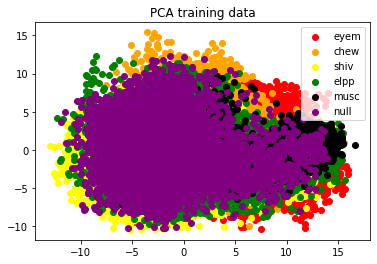

In [36]:
#PCA plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train = pca.fit_transform(Xtrain)
y = np.argmax(ytrain, axis = 1)
print(y[0], ytrain[0])
print(train.shape, y.shape)
#plot

z,o,t,th,f,n = train[y ==0], train[y ==1], train[y ==2], train[y ==3], train[y ==4], train[y ==5]

#m = plt.scatter(trainmix[900:,0], trainmix[900:,1], c= ymix[900:])

p0 = plt.scatter(z[:,0], z[:,1], marker='o', color='red')
p1 = plt.scatter(o[:,0], o[:,1], marker='o', color='orange')
p2 = plt.scatter(t[:,0], t[:,1], marker='o', color='yellow')
p3 = plt.scatter(th[:,0], th[:,1], marker='o', color='green')
p4 = plt.scatter(f[:,0], f[:,1], marker='o', color='black')
p5 = plt.scatter(n[:,0], n[:,1], marker='o', color='purple')

#plt.scatter(mixup[:,0], mixup[:,1], marker='x', color='b')
plt.title('PCA training data')
plt.legend((p0,p1,p2,p3,p4, p5),( 'eyem', 'chew','shiv','elpp','musc', 'null'))
plt.show()

1 [0.         0.72118325 0.         0.27881675 0.         0.        ]
(41962, 2) (41962,)


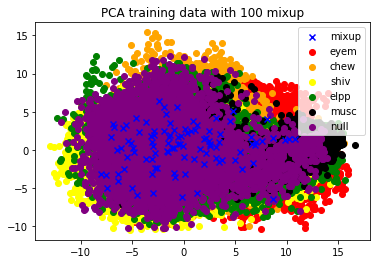

In [41]:
#PCA plot

trainmix = pca.fit_transform(X_train_mix)
ymix = np.argmax(y_train_mix, 1)
print(ymix[0], y_train_mix[0])
print(trainmix.shape, ymix.shape)
#plot
'''col = [0]*len(ymix)
np.where()
col = np.where(ymix<1,'k',np.where(y<5,'b','r'))
'''
mixup = trainmix[:100]
train = trainmix[100:]
mixupy = ymix[:100]
y = ymix[100:]

z,o,t,th,f,n = train[y ==0], train[y ==1], train[y ==2], train[y ==3], train[y ==4], train[y ==5]


#m = plt.scatter(trainmix[900:,0], trainmix[900:,1], c= ymix[900:])

p0 = plt.scatter(z[:,0], z[:,1], marker='o', color='red')
p1 = plt.scatter(o[:,0], o[:,1], marker='o', color='orange')
p2 = plt.scatter(t[:,0], t[:,1], marker='o', color='yellow')
p3 = plt.scatter(th[:,0], th[:,1], marker='o', color='green')
p4 = plt.scatter(f[:,0], f[:,1], marker='o', color='black')
p5 = plt.scatter(n[:,0], n[:,1], marker='o', color='purple')

m = plt.scatter(mixup[:,0], mixup[:,1], marker = 'x', color = 'blue')

#plt.scatter(mixup[:,0], mixup[:,1], marker='x', color='b')
plt.title('PCA training data with 100 mixup')
plt.legend((m, p0,p1,p2,p3,p4, p5),( 'mixup', 'eyem', 'chew','shiv','elpp','musc', 'null'))
plt.show()
